In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt

import torch
import numpy as np
from matplotlib import pyplot as plt

os.chdir('/home/jp4474/latent-abc-smc')

from systems import SpatialSIR, SpatialSIR3D
from models import MaskedAutoencoderViT, MaskedAutoencoderViT3D
from lightning_module import PreTrainLightningSpatial2D

2025-06-24 06:07:49.850567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 06:07:49.859228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750745269.868867 2034067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750745269.871835 2034067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750745269.880183 2034067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
spatial_abc = SpatialSIR3D()

INFO:latent_abc_pmc:Initializing ViaABC class
INFO:latent_abc_pmc:Initialization complete
INFO:latent_abc_pmc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_pmc:num_parameters: 2
INFO:latent_abc_pmc:Mu: [0.2 0.2]
INFO:latent_abc_pmc:Sigma: [4.5 4.5]
INFO:latent_abc_pmc:t0: 0
INFO:latent_abc_pmc:tmax: 16
INFO:latent_abc_pmc:time_space: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
INFO:latent_abc_pmc:pooling_method: no_cls
INFO:latent_abc_pmc:metric: pairwise_cosine


In [3]:
from inference_utils import load_pretrained_model, labels2map

In [4]:
pl_model = load_pretrained_model(
    folder_name="/home/jp4474/latent-abc-smc/spatialSIR3D_d128_ed64_6_8_4_8_ae_mask_0.15",
    model_class=MaskedAutoencoderViT3D,
    lightning_class=PreTrainLightningSpatial2D,
    checkpoint_substr="SIR"
)

img_size (80, 80) patch_size (8, 8) frames 15 t_patch_size 3
model initialized
Successfully loaded model


In [5]:
from dataset import SpatialSIRDataset

In [6]:
train_ds = SpatialSIRDataset("/home/jp4474/latent-abc-smc/data/SPATIAL", "val")

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

In [8]:
#x = next(iter(train_dl)).float().to(pl_model.device) #.squeeze(0).permute(0, 3, 1, 2)

In [9]:
x = spatial_abc.simulate([1, 1])[0]

In [10]:
x.shape

(3, 15, 80, 80)

In [11]:
# x = labels2map(x)

In [ ]:
# # 
# x = np.load("/home/jp4474/latent-abc-smc/data/SPATIAL/data.npy")
# x = labels2map(x)
x = torch.tensor(x).float().to(pl_model.device).unsqueeze(0)

In [13]:
x.shape

torch.Size([1, 3, 15, 80, 80])

In [14]:
with torch.no_grad():
    x_, mask, ids_restore = pl_model.model.forward_encoder(x, 0.0)
    y = pl_model.model.forward_decoder(x_, ids_restore)
    loss = pl_model.model.forward_loss(x, y, mask)
    y = pl_model.model.unpatchify(y)
    y = y.argmax(1).cpu().numpy()

In [15]:
x_.shape

torch.Size([1, 500, 128])

In [16]:
x.shape, y.shape

(torch.Size([1, 3, 15, 80, 80]), (1, 15, 80, 80))

In [17]:
x = x.squeeze(0).argmax(0).cpu().numpy()
y = y.squeeze(0)

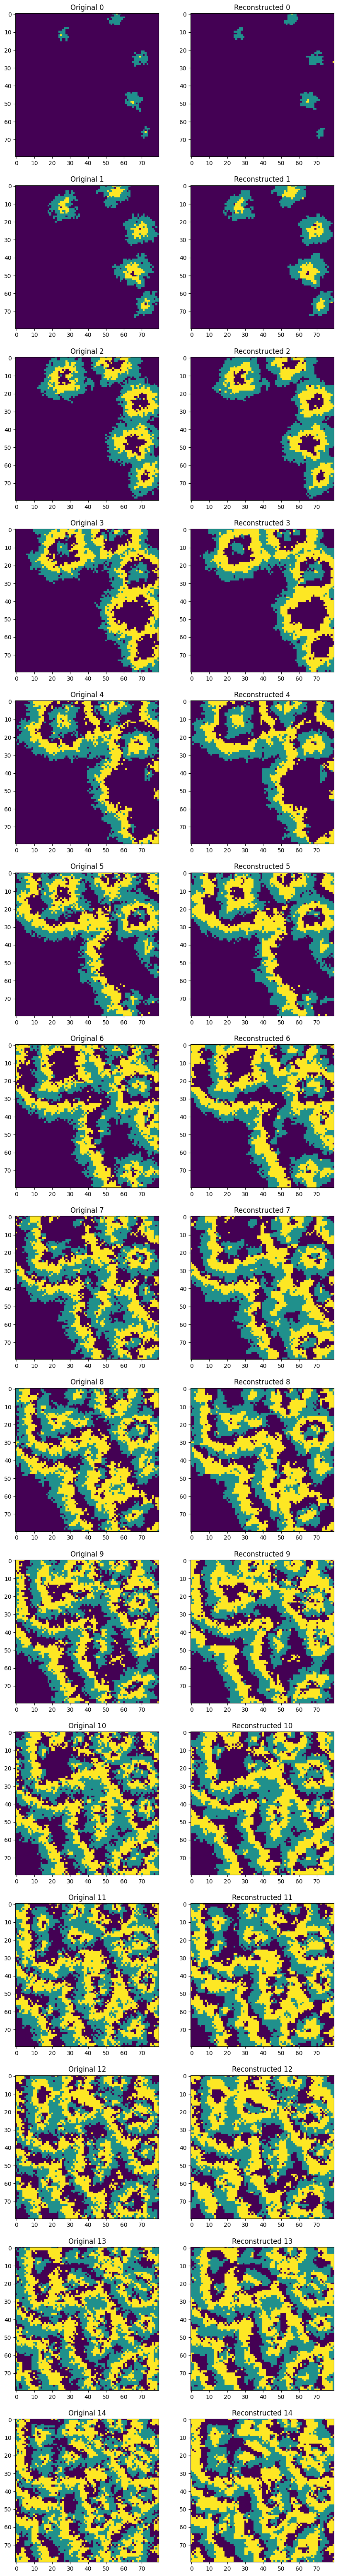

In [18]:
fig, ax = plt.subplots(15, 2, figsize=(10, 80))

for i in range(15):
    ax[i, 0].imshow(x[i], cmap='viridis')
    ax[i, 0].set_title(f"Original {i}")
    ax[i, 1].imshow(y[i], cmap='viridis')
    ax[i, 1].set_title(f"Reconstructed {i}")